# 05 - Credit Risk Modeling

Train and evaluate machine learning models for credit risk prediction.

**Models**:

- Baseline: Logistic Regression (interpretable, industry standard)
- Advanced: Random Forest Classifier
- Advanced: Gradient Boosting Classifier

**Evaluation**: ROC-AUC, Confusion Matrix


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    precision_recall_curve,
    average_precision_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# Paths
PROCESSED_DATA = Path("../data/processed/lending_club_processed.parquet")
MODELS_DIR = Path("../models/trained")
SCALERS_DIR = Path("../models/scalers")
FIGURES_DIR = Path("../reports/figures")

MODELS_DIR.mkdir(parents=True, exist_ok=True)
SCALERS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# Load processed data
df = pd.read_parquet(PROCESSED_DATA)
print(f"Loaded data shape: {df.shape}")

# Separate features and target
X = df.drop(columns=["default"])
y = df["default"]

print(f"\nFeatures: {X.shape[1]}")
print(f"Target distribution:")
print(y.value_counts(normalize=True).round(3))

Loaded data shape: (1345310, 101)

Features: 100
Target distribution:
default
0    0.8
1    0.2
Name: proportion, dtype: float64


## 1. Train-Test Split


In [ ]:
# 80/20 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(
    f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0] / len(X) * 100:.0f}%)"
)
print(
    f"Test set:     {X_test.shape[0]:,} samples ({X_test.shape[0] / len(X) * 100:.0f}%)"
)
print(f"\nTrain default rate: {y_train.mean():.2%}")
print(f"Test default rate:  {y_test.mean():.2%}")

Training set: 1,076,248 samples (80%)
Test set:     269,062 samples (20%)

Train default rate: 19.96%
Test default rate:  19.96%


## 2. Feature Scaling


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for production use
joblib.dump(scaler, SCALERS_DIR / "standard_scaler.joblib")
print("Scaler saved to:", SCALERS_DIR / "standard_scaler.joblib")

Scaler saved to: ../models/scalers/standard_scaler.joblib


## 3. Baseline Model: Logistic Regression

Industry standard for credit scorecards due to interpretability.


In [ ]:
print("=" * 60)
print("BASELINE: Logistic Regression")
print("=" * 60)

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight="balanced",  # Handle class imbalance
)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"\nROC-AUC Score: {roc_auc_lr:.4f}")
print(f"\nClassification Report:")
print(
    classification_report(y_test, y_pred_lr, target_names=["Fully Paid", "Defaulted"])
)

BASELINE: Logistic Regression

ROC-AUC Score: 0.9481

Classification Report:
              precision    recall  f1-score   support

  Fully Paid       0.97      0.89      0.93    215350
   Defaulted       0.67      0.89      0.77     53712

    accuracy                           0.89    269062
   macro avg       0.82      0.89      0.85    269062
weighted avg       0.91      0.89      0.90    269062



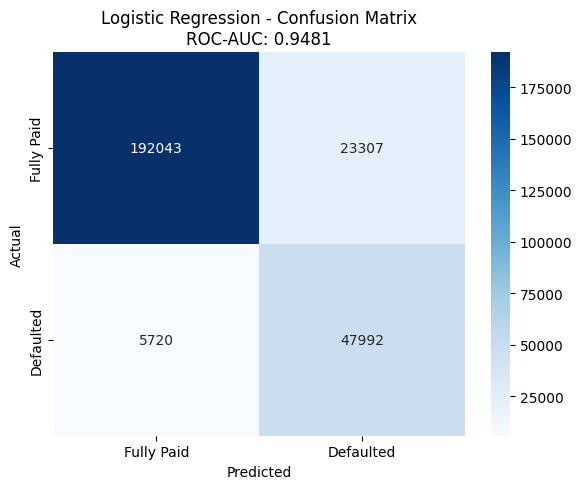

In [ ]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax,
    xticklabels=["Fully Paid", "Defaulted"],
    yticklabels=["Fully Paid", "Defaulted"],
)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title(f"Logistic Regression - Confusion Matrix\nROC-AUC: {roc_auc_lr:.4f}")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "confusion_matrix_lr.png", dpi=150)
plt.show()

## 4. Advanced Model: Random Forest


In [7]:
print("=" * 60)
print("ADVANCED: Random Forest Classifier")
print("=" * 60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"\nROC-AUC Score: {roc_auc_rf:.4f}")
print(f"\nClassification Report:")
print(
    classification_report(y_test, y_pred_rf, target_names=["Fully Paid", "Defaulted"])
)

ADVANCED: Random Forest Classifier

ROC-AUC Score: 0.9484

Classification Report:
              precision    recall  f1-score   support

  Fully Paid       0.98      0.87      0.92    215350
   Defaulted       0.63      0.92      0.75     53712

    accuracy                           0.88    269062
   macro avg       0.80      0.89      0.83    269062
weighted avg       0.91      0.88      0.89    269062



## 5. Advanced Model: Gradient Boosting

- Gradient Boosting is slow on large datasets because it trains trees sequentially

* Large (1M+) Hours (1-4+ hrs)

- 1.8M row


In [11]:
# print("=" * 60)
# print("ADVANCED: Gradient Boosting Classifier")
# print("=" * 60)

# gb_model = GradientBoostingClassifier(
#     n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
# )
# gb_model.fit(X_train_scaled, y_train)

# # Predictions
# y_pred_gb = gb_model.predict(X_test_scaled)
# y_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# # Evaluation
# roc_auc_gb = roc_auc_score(y_test, y_prob_gb)
# print(f"\nROC-AUC Score: {roc_auc_gb:.4f}")
# print(f"\nClassification Report:")
# print(
#     classification_report(y_test, y_pred_gb, target_names=["Fully Paid", "Defaulted"])
# )


# Sample:
# Save Logistic Regression as the final model
import joblib

joblib.dump(lr_model, MODELS_DIR / "credit_risk_model.joblib")
joblib.dump(X.columns.tolist(), MODELS_DIR / "feature_names.joblib")

print("Model saved!")
print(f"ROC-AUC: {roc_auc_lr:.4f}")

Model saved!
ROC-AUC: 0.9481


## 6. Model Comparison


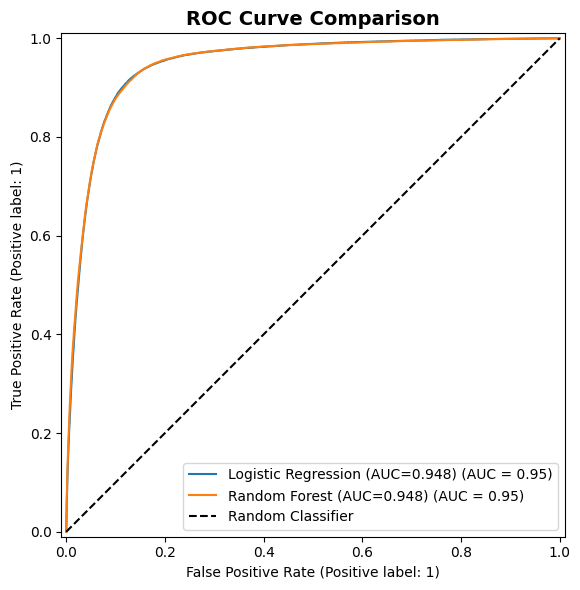

Saved Random Forest model (ROC-AUC: 0.9484)


In [ ]:
# # ROC Curve Comparison
# fig, ax = plt.subplots(figsize=(8, 6))

# RocCurveDisplay.from_predictions(
#     y_test, y_prob_lr, name=f"Logistic Regression (AUC={roc_auc_lr:.3f})", ax=ax
# )
# RocCurveDisplay.from_predictions(
#     y_test, y_prob_rf, name=f"Random Forest (AUC={roc_auc_rf:.3f})", ax=ax
# )
# RocCurveDisplay.from_predictions(
#     y_test, y_prob_gb, name=f"Gradient Boosting (AUC={roc_auc_gb:.3f})", ax=ax
# )

# ax.plot([0, 1], [0, 1], "k--", label="Random Classifier")
# ax.set_title("ROC Curve Comparison", fontsize=14, fontweight="bold")
# ax.legend(loc="lower right")

# plt.tight_layout()
# plt.savefig(FIGURES_DIR / "roc_comparison.png", dpi=150)
# plt.show()


# Sample:
# ROC Curve Comparison (LR and RF only)
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(
    y_test, y_prob_lr, name=f"Logistic Regression (AUC={roc_auc_lr:.3f})", ax=ax
)
RocCurveDisplay.from_predictions(
    y_test, y_prob_rf, name=f"Random Forest (AUC={roc_auc_rf:.3f})", ax=ax
)

ax.plot([0, 1], [0, 1], "k--", label="Random Classifier")
ax.set_title("ROC Curve Comparison", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")

plt.tight_layout()
plt.savefig(FIGURES_DIR / "roc_comparison.png", dpi=150)
plt.show()

# Save the best model (Random Forest slightly better)
joblib.dump(rf_model, MODELS_DIR / "credit_risk_model.joblib")
joblib.dump(X.columns.tolist(), MODELS_DIR / "feature_names.joblib")
print(f"Saved Random Forest model (ROC-AUC: {roc_auc_rf:.4f})")


In [ ]:
# # Model comparison summary
# results = pd.DataFrame(
#     {
#         "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting"],
#         "ROC-AUC": [roc_auc_lr, roc_auc_rf, roc_auc_gb],
#     }
# ).sort_values("ROC-AUC", ascending=False)

# print("\n" + "=" * 60)
# print("MODEL COMPARISON")
# print("=" * 60)
# print(results.to_string(index=False))

# best_model_name = results.iloc[0]["Model"]
# print(f"\nBest Model: {best_model_name}")


# Sample:

# Model comparison (without GB)
results = pd.DataFrame(
    {
        "Model": ["Logistic Regression", "Random Forest"],
        "ROC-AUC": [roc_auc_lr, roc_auc_rf],
    }
).sort_values("ROC-AUC", ascending=False)

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(results.to_string(index=False))
print(f"\nBest Model: {results.iloc[0]['Model']}")


MODEL COMPARISON
              Model  ROC-AUC
      Random Forest 0.948363
Logistic Regression 0.948050

Best Model: Random Forest


## 7. Feature Importance


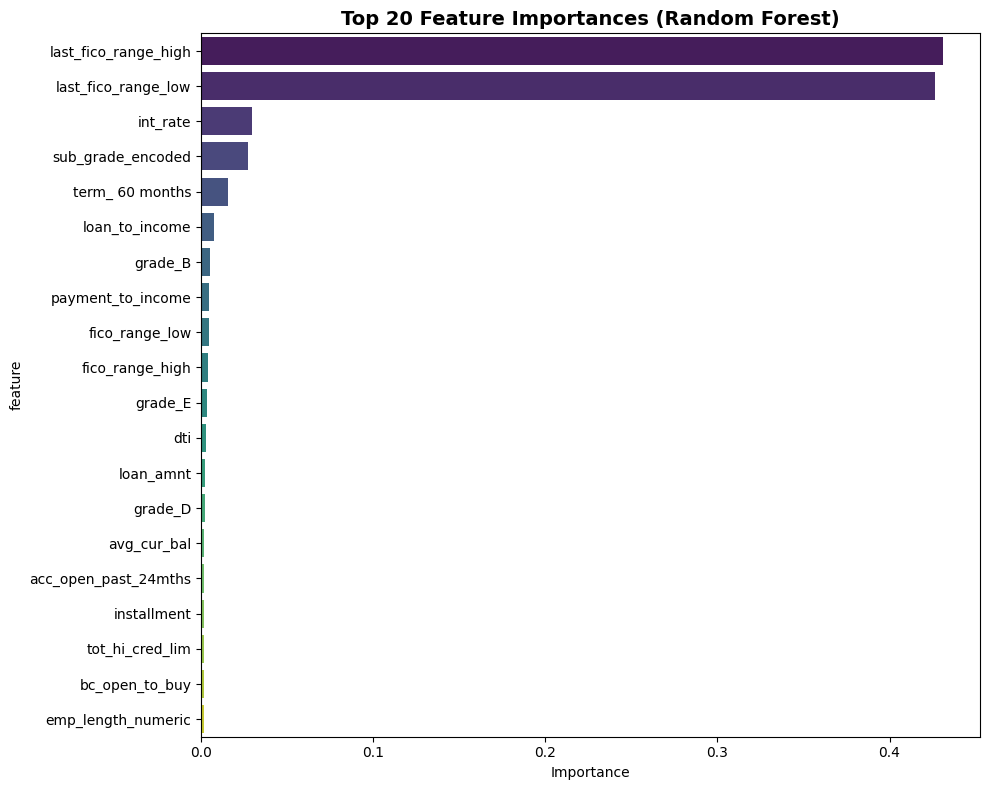

In [16]:
# Random Forest feature importance
feature_importance = (
    pd.DataFrame({"feature": X.columns, "importance": rf_model.feature_importances_})
    .sort_values("importance", ascending=False)
    .head(20)
)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(
    data=feature_importance, x="importance", y="feature", ax=ax, palette="viridis"
)
ax.set_title(
    "Top 20 Feature Importances (Random Forest)", fontsize=14, fontweight="bold"
)
ax.set_xlabel("Importance")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "feature_importance.png", dpi=150)
plt.show()

## 8. Save Best Model


In [18]:
# Select best model based on ROC-AUC
# models = {
#     "Logistic Regression": (lr_model, roc_auc_lr),
#     "Random Forest": (rf_model, roc_auc_rf),
#     "Gradient Boosting": (gb_model, roc_auc_gb),
# }

# best_name = max(models, key=lambda x: models[x][1])
# best_model = models[best_name][0]
# best_auc = models[best_name][1]

# print(f"Saving best model: {best_name} (ROC-AUC: {best_auc:.4f})")

# # Save model and feature names
# joblib.dump(best_model, MODELS_DIR / "credit_risk_model.joblib")
# joblib.dump(X.columns.tolist(), MODELS_DIR / "feature_names.joblib")

# print(f"Model saved to: {MODELS_DIR / 'credit_risk_model.joblib'}")
# print(f"Feature names saved to: {MODELS_DIR / 'feature_names.joblib'}")

# Sample:
# Save best model (without GB)
models = {
    "Logistic Regression": (lr_model, roc_auc_lr),
    "Random Forest": (rf_model, roc_auc_rf),
}

best_name = max(models, key=lambda x: models[x][1])
best_model = models[best_name][0]
best_auc = models[best_name][1]

print(f"Saving best model: {best_name} (ROC-AUC: {best_auc:.4f})")

joblib.dump(best_model, MODELS_DIR / "credit_risk_model.joblib")
joblib.dump(X.columns.tolist(), MODELS_DIR / "feature_names.joblib")

print(f"Model saved to: {MODELS_DIR / 'credit_risk_model.joblib'}")

Saving best model: Random Forest (ROC-AUC: 0.9484)
Model saved to: ../models/trained/credit_risk_model.joblib


## 9. Summary


In [ ]:
print("\n" + "=" * 60)
print("MODELING COMPLETE")
print("=" * 60)
print(f"""
Training Summary:
- Training samples: {len(y_train):,}
- Test samples: {len(y_test):,}
- Features: {X.shape[1]}

Best Model: {best_name}
- ROC-AUC: {best_auc:.4f}

Files Saved:
- {MODELS_DIR / "credit_risk_model.joblib"}
- {MODELS_DIR / "feature_names.joblib"}
- {SCALERS_DIR / "standard_scaler.joblib"}

Next: Use src/api/risk_scorer.py for production predictions
""")


joblib.dump(rf_model, MODELS_DIR / "credit_risk_model.joblib")
joblib.dump(scaler, SCALERS_DIR / "standard_scaler.joblib")
joblib.dump(X.columns.tolist(), MODELS_DIR / "feature_names.joblib")
print("Saved!")


MODELING COMPLETE

Training Summary:
- Training samples: 1,076,248
- Test samples: 269,062
- Features: 100

Best Model: Random Forest
- ROC-AUC: 0.9484

Files Saved:
- ../models/trained/credit_risk_model.joblib
- ../models/trained/feature_names.joblib
- ../models/scalers/standard_scaler.joblib

Next: Use src/api/risk_scorer.py for production predictions

Saved!
